In [2]:
#python3 -m notebook
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
%pylab inline
from tqdm import tqdm


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Fitting kernel at 64**3 particles resolution

In [3]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [4]:
#export PYTHONPATH="$PYTHONPATH//home/george/CAMELS/library/build/lib"
# import sys
# sys.path.append('home/george/CAMELS/library/build/lib')
#import camels_library as cl
import readgadget
import numpy as np

init_cond = 'CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [5]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [02:22<00:00,  4.20s/it]


In [6]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)

In [7]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

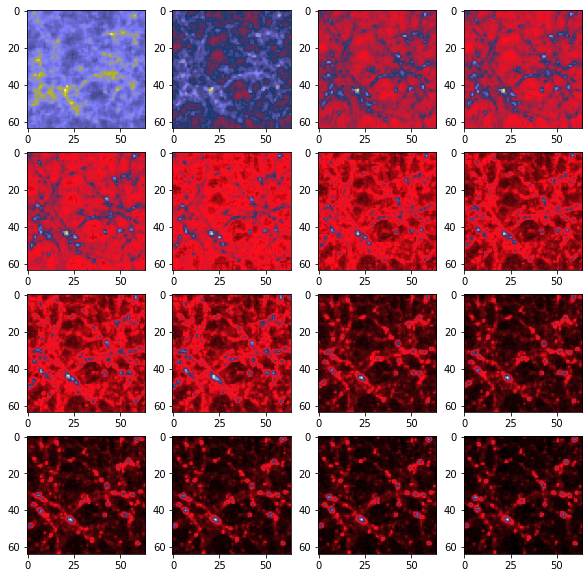

In [8]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

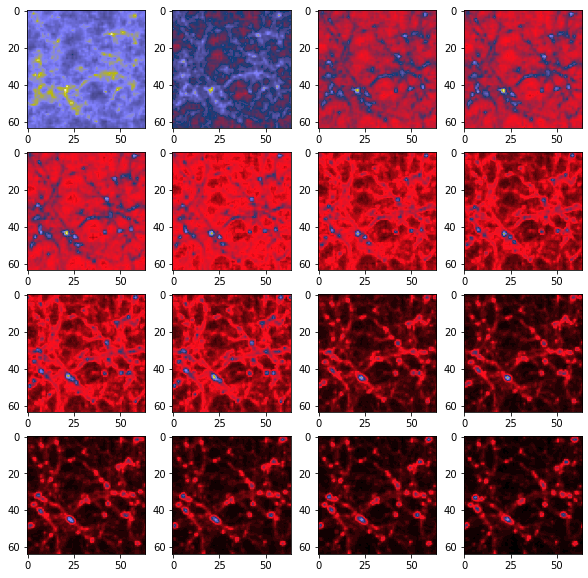

In [9]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [10]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

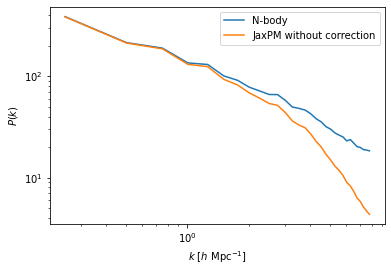

In [11]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [12]:
# Instantiate the neural network
# model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter()(x,a)))

# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [13]:
from  Net3d import*




# Instantiate the neural network

model = hk.without_apply_rng(hk.transform(lambda x : SpectralConv3()(x)))

#params = model.init(next(rng_seq),jnp.zeros([1,1,64,64,33]))

In [15]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k = pot_k[jax.numpy.newaxis,jax.numpy.newaxis,...]
    #pot_k=pot_k.reshape(1,1,64,64,33)
    pot_k = pot_k + model.apply(params, pot_k)
    pot_k=jax.numpy.squeeze(pot_k)

    #print(model.apply(params, kk, jnp.atleast_1d(a)))
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [22]:
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  # Optional lines to include velocity in the loss
  vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  wv = jnp.where(distance < 100, vel, 0.)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [13]:
losses = []

In [26]:
import optax
lr_fun= optax.cosine_decay_schedule(0.01, 1000 , alpha=0.0) #0.1 for 400steps, 0.01
#learning_rate=0.001
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [27]:
for step in tqdm(range(10000)):
  l, params, opt_state = update(params, opt_state)
  if(step%10==0):
    print("Step: ", step, " Loss: ",l)
  losses.append(l)

  0%|          | 1/10000 [00:03<10:02:52,  3.62s/it]

Step:  0  Loss:  0.29947925


  0%|          | 11/10000 [00:40<10:06:26,  3.64s/it]

Step:  10  Loss:  0.32859984


  0%|          | 21/10000 [01:16<10:02:51,  3.62s/it]

Step:  20  Loss:  0.31101543


  0%|          | 31/10000 [01:52<10:02:36,  3.63s/it]

Step:  30  Loss:  0.3035448


  0%|          | 41/10000 [02:28<10:02:05,  3.63s/it]

Step:  40  Loss:  0.30117998


  1%|          | 51/10000 [03:05<10:01:24,  3.63s/it]

Step:  50  Loss:  0.29999498


  1%|          | 61/10000 [03:41<10:00:48,  3.63s/it]

Step:  60  Loss:  0.29936692


  1%|          | 71/10000 [04:17<10:00:07,  3.63s/it]

Step:  70  Loss:  0.29902205


  1%|          | 81/10000 [04:53<9:59:35,  3.63s/it] 

Step:  80  Loss:  0.29878694


  1%|          | 91/10000 [05:30<9:58:51,  3.63s/it]

Step:  90  Loss:  0.29860783


  1%|          | 101/10000 [06:06<9:58:24,  3.63s/it]

Step:  100  Loss:  0.2984491


  1%|          | 111/10000 [06:42<9:57:37,  3.63s/it]

Step:  110  Loss:  0.2983126


  1%|          | 121/10000 [07:18<9:57:10,  3.63s/it]

Step:  120  Loss:  0.29823598


  1%|▏         | 131/10000 [07:55<9:57:06,  3.63s/it]

Step:  130  Loss:  0.29807985


  1%|▏         | 141/10000 [08:31<9:56:32,  3.63s/it]

Step:  140  Loss:  0.29796687


  2%|▏         | 151/10000 [09:07<9:57:02,  3.64s/it]

Step:  150  Loss:  0.29791847


  2%|▏         | 161/10000 [09:44<9:56:45,  3.64s/it]

Step:  160  Loss:  0.2977988


  2%|▏         | 171/10000 [10:20<9:56:10,  3.64s/it]

Step:  170  Loss:  0.29766145


  2%|▏         | 181/10000 [10:56<9:55:37,  3.64s/it]

Step:  180  Loss:  0.29758278


  2%|▏         | 191/10000 [11:33<9:54:57,  3.64s/it]

Step:  190  Loss:  0.29759884


  2%|▏         | 201/10000 [12:09<9:54:27,  3.64s/it]

Step:  200  Loss:  0.29747754


  2%|▏         | 211/10000 [12:46<9:53:48,  3.64s/it]

Step:  210  Loss:  0.29737252


  2%|▏         | 221/10000 [13:22<9:53:13,  3.64s/it]

Step:  220  Loss:  0.29720154


  2%|▏         | 231/10000 [13:58<9:52:28,  3.64s/it]

Step:  230  Loss:  0.29716343


  2%|▏         | 241/10000 [14:35<9:51:57,  3.64s/it]

Step:  240  Loss:  0.2970405


  3%|▎         | 251/10000 [15:11<9:51:24,  3.64s/it]

Step:  250  Loss:  0.29687256


  3%|▎         | 261/10000 [15:48<9:50:44,  3.64s/it]

Step:  260  Loss:  0.29681194


  3%|▎         | 271/10000 [16:24<9:50:06,  3.64s/it]

Step:  270  Loss:  0.29678756


  3%|▎         | 281/10000 [17:00<9:49:36,  3.64s/it]

Step:  280  Loss:  0.29665092


  3%|▎         | 291/10000 [17:37<9:48:54,  3.64s/it]

Step:  290  Loss:  0.29673296


  3%|▎         | 301/10000 [18:13<9:48:20,  3.64s/it]

Step:  300  Loss:  0.29653695


  3%|▎         | 311/10000 [18:50<9:47:40,  3.64s/it]

Step:  310  Loss:  0.29645756


  3%|▎         | 321/10000 [19:26<9:46:59,  3.64s/it]

Step:  320  Loss:  0.29641747


  3%|▎         | 331/10000 [20:02<9:46:25,  3.64s/it]

Step:  330  Loss:  0.29633668


  3%|▎         | 341/10000 [20:39<9:45:44,  3.64s/it]

Step:  340  Loss:  0.29623002


  4%|▎         | 351/10000 [21:15<9:45:10,  3.64s/it]

Step:  350  Loss:  0.29622394


  4%|▎         | 361/10000 [21:52<9:44:30,  3.64s/it]

Step:  360  Loss:  0.29618752


  4%|▎         | 371/10000 [22:28<9:44:02,  3.64s/it]

Step:  370  Loss:  0.2960718


  4%|▍         | 381/10000 [23:04<9:43:27,  3.64s/it]

Step:  380  Loss:  0.29599693


  4%|▍         | 391/10000 [23:41<9:42:57,  3.64s/it]

Step:  390  Loss:  0.29598716


  4%|▍         | 401/10000 [24:17<9:42:15,  3.64s/it]

Step:  400  Loss:  0.29589716


  4%|▍         | 411/10000 [24:54<9:41:35,  3.64s/it]

Step:  410  Loss:  0.29586956


  4%|▍         | 421/10000 [25:30<9:40:59,  3.64s/it]

Step:  420  Loss:  0.29574525


  4%|▍         | 431/10000 [26:06<9:40:25,  3.64s/it]

Step:  430  Loss:  0.29580316


  4%|▍         | 441/10000 [26:43<9:39:45,  3.64s/it]

Step:  440  Loss:  0.29563504


  5%|▍         | 451/10000 [27:19<9:39:14,  3.64s/it]

Step:  450  Loss:  0.29558104


  5%|▍         | 461/10000 [27:56<9:38:34,  3.64s/it]

Step:  460  Loss:  0.29556495


  5%|▍         | 471/10000 [28:32<9:38:00,  3.64s/it]

Step:  470  Loss:  0.29558626


  5%|▍         | 481/10000 [29:08<9:37:24,  3.64s/it]

Step:  480  Loss:  0.29548734


  5%|▍         | 491/10000 [29:45<9:36:43,  3.64s/it]

Step:  490  Loss:  0.29541248


  5%|▌         | 501/10000 [30:21<9:36:10,  3.64s/it]

Step:  500  Loss:  0.29538554


  5%|▌         | 511/10000 [30:57<9:35:30,  3.64s/it]

Step:  510  Loss:  0.29535055


  5%|▌         | 521/10000 [31:34<9:34:54,  3.64s/it]

Step:  520  Loss:  0.29529238


  5%|▌         | 531/10000 [32:10<9:34:20,  3.64s/it]

Step:  530  Loss:  0.29525805


  5%|▌         | 541/10000 [32:47<9:33:36,  3.64s/it]

Step:  540  Loss:  0.29521734


  6%|▌         | 551/10000 [33:23<9:33:03,  3.64s/it]

Step:  550  Loss:  0.2951875


  6%|▌         | 561/10000 [33:59<9:32:27,  3.64s/it]

Step:  560  Loss:  0.295173


  6%|▌         | 571/10000 [34:36<9:32:00,  3.64s/it]

Step:  570  Loss:  0.29515082


  6%|▌         | 581/10000 [35:12<9:31:16,  3.64s/it]

Step:  580  Loss:  0.29512525


  6%|▌         | 591/10000 [35:49<9:30:45,  3.64s/it]

Step:  590  Loss:  0.2950828


  6%|▌         | 601/10000 [36:25<9:30:00,  3.64s/it]

Step:  600  Loss:  0.29504836


  6%|▌         | 611/10000 [37:01<9:29:29,  3.64s/it]

Step:  610  Loss:  0.29502714


  6%|▌         | 621/10000 [37:38<9:28:51,  3.64s/it]

Step:  620  Loss:  0.29500324


  6%|▋         | 631/10000 [38:14<9:28:17,  3.64s/it]

Step:  630  Loss:  0.2949807


  6%|▋         | 641/10000 [38:51<9:27:35,  3.64s/it]

Step:  640  Loss:  0.29496208


  7%|▋         | 651/10000 [39:27<9:27:02,  3.64s/it]

Step:  650  Loss:  0.29494464


  7%|▋         | 661/10000 [40:03<9:26:21,  3.64s/it]

Step:  660  Loss:  0.2949246


  7%|▋         | 671/10000 [40:40<9:25:52,  3.64s/it]

Step:  670  Loss:  0.29491046


  7%|▋         | 681/10000 [41:16<9:25:13,  3.64s/it]

Step:  680  Loss:  0.29489642


  7%|▋         | 691/10000 [41:53<9:24:43,  3.64s/it]

Step:  690  Loss:  0.29488045


  7%|▋         | 701/10000 [42:29<9:24:00,  3.64s/it]

Step:  700  Loss:  0.2948662


  7%|▋         | 711/10000 [43:05<9:23:32,  3.64s/it]

Step:  710  Loss:  0.29485202


  7%|▋         | 721/10000 [43:42<9:22:51,  3.64s/it]

Step:  720  Loss:  0.29483998


  7%|▋         | 731/10000 [44:18<9:22:21,  3.64s/it]

Step:  730  Loss:  0.29483002


  7%|▋         | 741/10000 [44:54<9:21:41,  3.64s/it]

Step:  740  Loss:  0.2948205


  8%|▊         | 751/10000 [45:31<9:21:07,  3.64s/it]

Step:  750  Loss:  0.29481098


  8%|▊         | 761/10000 [46:07<9:20:24,  3.64s/it]

Step:  760  Loss:  0.29480165


  8%|▊         | 771/10000 [46:44<9:19:50,  3.64s/it]

Step:  770  Loss:  0.29479173


  8%|▊         | 781/10000 [47:20<9:19:13,  3.64s/it]

Step:  780  Loss:  0.29478526


  8%|▊         | 791/10000 [47:56<9:18:35,  3.64s/it]

Step:  790  Loss:  0.29477876


  8%|▊         | 801/10000 [48:33<9:18:03,  3.64s/it]

Step:  800  Loss:  0.29477277


  8%|▊         | 811/10000 [49:09<9:17:25,  3.64s/it]

Step:  810  Loss:  0.2947676


  8%|▊         | 821/10000 [49:46<9:16:46,  3.64s/it]

Step:  820  Loss:  0.2947629


  8%|▊         | 831/10000 [50:22<9:16:04,  3.64s/it]

Step:  830  Loss:  0.2947585


  8%|▊         | 841/10000 [50:58<9:15:33,  3.64s/it]

Step:  840  Loss:  0.2947534


  9%|▊         | 851/10000 [51:35<9:15:00,  3.64s/it]

Step:  850  Loss:  0.2947517


  9%|▊         | 861/10000 [52:11<9:14:29,  3.64s/it]

Step:  860  Loss:  0.2947477


  9%|▊         | 871/10000 [52:48<9:13:55,  3.64s/it]

Step:  870  Loss:  0.29474494


  9%|▉         | 881/10000 [53:24<9:13:08,  3.64s/it]

Step:  880  Loss:  0.29474187


  9%|▉         | 891/10000 [54:00<9:12:40,  3.64s/it]

Step:  890  Loss:  0.29473984


  9%|▉         | 901/10000 [54:37<9:12:01,  3.64s/it]

Step:  900  Loss:  0.2947385


  9%|▉         | 911/10000 [55:13<9:11:17,  3.64s/it]

Step:  910  Loss:  0.29473668


  9%|▉         | 921/10000 [55:50<9:10:42,  3.64s/it]

Step:  920  Loss:  0.29473582


  9%|▉         | 931/10000 [56:26<9:10:06,  3.64s/it]

Step:  930  Loss:  0.2947349


  9%|▉         | 941/10000 [57:02<9:09:34,  3.64s/it]

Step:  940  Loss:  0.29473326


 10%|▉         | 951/10000 [57:39<9:08:51,  3.64s/it]

Step:  950  Loss:  0.2947324


 10%|▉         | 961/10000 [58:15<9:08:20,  3.64s/it]

Step:  960  Loss:  0.2947322


 10%|▉         | 971/10000 [58:52<9:07:40,  3.64s/it]

Step:  970  Loss:  0.29473197


 10%|▉         | 981/10000 [59:28<9:07:06,  3.64s/it]

Step:  980  Loss:  0.29473183


 10%|▉         | 991/10000 [1:00:04<9:06:27,  3.64s/it]

Step:  990  Loss:  0.29473168


 10%|█         | 1001/10000 [1:00:41<9:05:49,  3.64s/it]

Step:  1000  Loss:  0.2947317


 10%|█         | 1011/10000 [1:01:17<9:05:14,  3.64s/it]

Step:  1010  Loss:  0.29473183


 10%|█         | 1021/10000 [1:01:54<9:04:38,  3.64s/it]

Step:  1020  Loss:  0.29473177


 10%|█         | 1031/10000 [1:02:30<9:04:01,  3.64s/it]

Step:  1030  Loss:  0.29473186


 10%|█         | 1041/10000 [1:03:06<9:03:26,  3.64s/it]

Step:  1040  Loss:  0.29473168


 11%|█         | 1051/10000 [1:03:43<9:02:53,  3.64s/it]

Step:  1050  Loss:  0.2947317


 11%|█         | 1061/10000 [1:04:19<9:02:16,  3.64s/it]

Step:  1060  Loss:  0.29473177


 11%|█         | 1071/10000 [1:04:56<9:01:40,  3.64s/it]

Step:  1070  Loss:  0.2947318


 11%|█         | 1081/10000 [1:05:32<9:01:05,  3.64s/it]

Step:  1080  Loss:  0.29473186


 11%|█         | 1091/10000 [1:06:08<9:00:27,  3.64s/it]

Step:  1090  Loss:  0.2947317


 11%|█         | 1101/10000 [1:06:45<8:59:58,  3.64s/it]

Step:  1100  Loss:  0.29473174


 11%|█         | 1111/10000 [1:07:21<8:59:13,  3.64s/it]

Step:  1110  Loss:  0.29473165


 11%|█         | 1121/10000 [1:07:58<8:58:41,  3.64s/it]

Step:  1120  Loss:  0.2947317


 11%|█▏        | 1131/10000 [1:08:34<8:58:04,  3.64s/it]

Step:  1130  Loss:  0.2947318


 11%|█▏        | 1141/10000 [1:09:10<8:57:27,  3.64s/it]

Step:  1140  Loss:  0.29473186


 12%|█▏        | 1151/10000 [1:09:47<8:56:51,  3.64s/it]

Step:  1150  Loss:  0.29473174


 12%|█▏        | 1161/10000 [1:10:23<8:56:08,  3.64s/it]

Step:  1160  Loss:  0.29473177


 12%|█▏        | 1171/10000 [1:11:00<8:55:36,  3.64s/it]

Step:  1170  Loss:  0.29473168


 12%|█▏        | 1181/10000 [1:11:36<8:55:02,  3.64s/it]

Step:  1180  Loss:  0.29473177


 12%|█▏        | 1191/10000 [1:12:12<8:54:24,  3.64s/it]

Step:  1190  Loss:  0.2947317


 12%|█▏        | 1201/10000 [1:12:49<8:53:45,  3.64s/it]

Step:  1200  Loss:  0.29473168


 12%|█▏        | 1211/10000 [1:13:25<8:53:08,  3.64s/it]

Step:  1210  Loss:  0.2947318


 12%|█▏        | 1221/10000 [1:14:02<8:52:34,  3.64s/it]

Step:  1220  Loss:  0.29473183


 12%|█▏        | 1231/10000 [1:14:38<8:51:57,  3.64s/it]

Step:  1230  Loss:  0.29473168


 12%|█▏        | 1241/10000 [1:15:14<8:51:24,  3.64s/it]

Step:  1240  Loss:  0.29473165


 13%|█▎        | 1251/10000 [1:15:51<8:50:39,  3.64s/it]

Step:  1250  Loss:  0.29473191


 13%|█▎        | 1261/10000 [1:16:27<8:50:16,  3.64s/it]

Step:  1260  Loss:  0.29473186


 13%|█▎        | 1271/10000 [1:17:04<8:49:27,  3.64s/it]

Step:  1270  Loss:  0.29473174


 13%|█▎        | 1281/10000 [1:17:40<8:48:55,  3.64s/it]

Step:  1280  Loss:  0.29473174


 13%|█▎        | 1291/10000 [1:18:16<8:48:20,  3.64s/it]

Step:  1290  Loss:  0.29473191


 13%|█▎        | 1301/10000 [1:18:53<8:47:44,  3.64s/it]

Step:  1300  Loss:  0.29473183


 13%|█▎        | 1311/10000 [1:19:29<8:47:08,  3.64s/it]

Step:  1310  Loss:  0.29473174


 13%|█▎        | 1321/10000 [1:20:06<8:46:41,  3.64s/it]

Step:  1320  Loss:  0.2947317


 13%|█▎        | 1331/10000 [1:20:42<8:45:55,  3.64s/it]

Step:  1330  Loss:  0.29473186


 13%|█▎        | 1341/10000 [1:21:18<8:45:21,  3.64s/it]

Step:  1340  Loss:  0.29473177


 14%|█▎        | 1351/10000 [1:21:55<8:44:39,  3.64s/it]

Step:  1350  Loss:  0.2947318


 14%|█▎        | 1361/10000 [1:22:31<8:44:05,  3.64s/it]

Step:  1360  Loss:  0.29473183


 14%|█▎        | 1371/10000 [1:23:08<8:43:34,  3.64s/it]

Step:  1370  Loss:  0.29473165


 14%|█▍        | 1381/10000 [1:23:44<8:42:52,  3.64s/it]

Step:  1380  Loss:  0.2947318


 14%|█▍        | 1381/10000 [1:23:48<8:43:00,  3.64s/it]


KeyboardInterrupt: 

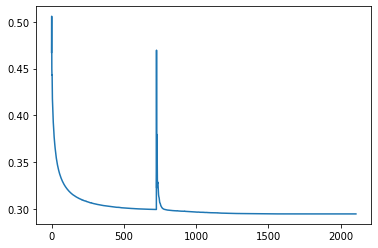

In [28]:
plot(losses)

In [ ]:
kvec = fftk(mesh_shape)
x=numpy.array(kvec)

# Apply a correction filter
kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
kk.shape

/tmp/ipykernel_1040253/1093470156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x=numpy.array(kvec)
/tmp/ipykernel_1040253/1093470156.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


(64, 64, 33)

In [29]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, paramsLoad, rtol=1e-5, atol=1e-5)

NameError: name 'neural_nbody_ode' is not defined

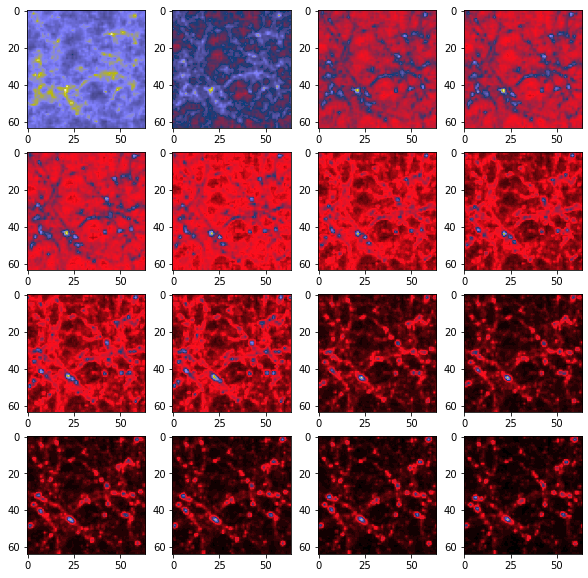

In [ ]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [ ]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

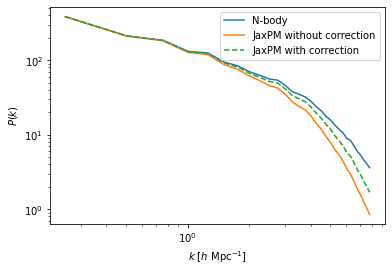

In [ ]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/hom

NameError: name 'sm' is not defined

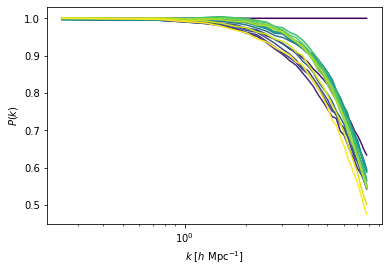

In [ ]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/hom

NameError: name 'sm' is not defined

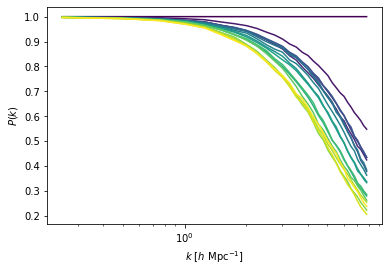

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

In [ ]:
w1=paramsLoad.get("Layer").get("Layerw1")
w2=paramsLoad.get("Layer").get("Layerw2")
w3=paramsLoad.get("Layer").get("Layerw3")
w4=paramsLoad.get("Layer").get("Layerw4")
w1=numpy.squeeze(w1)
w2=numpy.squeeze(w2)
w3=numpy.squeeze(w3)
w4=numpy.squeeze(w4)


kvals = jnp.logspace(-2.,0,100)*sqrt(3)

kvec = fftk(mesh_shape)

k = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


out_ft=jnp.zeros([64,64,33], dtype=float)
modes1,modes2,modes3=32,32,32
out_ft=out_ft.at[ :modes1, :modes2, :modes3].set(w1)

out_ft=out_ft.at[ -modes1:, :modes2, :modes3].set(w2)

out_ft=out_ft.at[ :modes1, -modes2:, :modes3].set(w3)

out_ft=out_ft.at[ -modes1:, -modes2:, :modes3].set(w4)


/tmp/ipykernel_3104184/854845210.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


In [ ]:
def funX():
    sum=[0]*len(kvals)
    count=[0]*len(kvals)
    out_ftX=numpy.array(out_ft)
    kX=numpy.array(k)
    kvalsX=numpy.array(kvals)
    # print((kvalsX))

    for i in range(64):
        for j in range(64):
            for z in range(33):
                for l in range(len(kvals)):
                    
                    if(kX[i][j][z]<kvalsX[0] and kX[i][j][z]<=kvalsX[1]):
                        sum[0]+=out_ftX[i][j][z]
                        count[0]+=1
                        break

                    if(kX[i][j][z]>kvalsX[l-1] and kX[i][j][z]<=kvalsX[l]):
                        sum[l]+=out_ftX[i][j][z]
                        count[l]+=1
                        break
    return count,sum        


In [ ]:
c,s=funX()

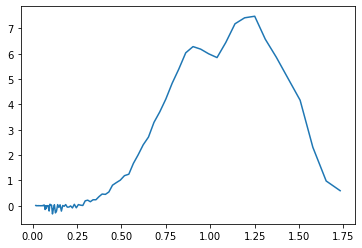

In [ ]:
aver=[0]*100
for i in range(len(c)):
    if(c[i]!=0):
        aver[i]=s[i]/c[i]
    else:
        aver[i]=0

plot(kvals,aver)

In [ ]:
# import pickle
# with (open("Spectral_CV0.params", "rb")) as openfile:
#     while True:
#         try:
#             paramsLoad=pickle.load(openfile)
#         except EOFError:
#             break

In [ ]:
# import pickle
# pickle.dump( params, open( "camels_25_64_pos_vel.params", "wb" ) )